# Plots para la tesis

Imports


In [138]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pathlib import Path
from scipy.io import wavfile
import librosa
import soundfile as sf

Paths a los archivos de resultados

In [139]:
current_path = Path.cwd()
audio_folder = current_path.parent / 'audio-files'
plots_folder = Path('/home/jalma/Repositories/tesis-untref/Figuras/resultados')

systems = [folder.name for folder in (audio_folder).iterdir() if folder.is_dir()]

protocol_columns = ['speaker_id', 'file_name', 'attack', 'key', 'duration']    
#protocol_df = pd.read_csv('D:/Music/datasets/Dataset/protocol-spoofed.txt', sep='\s+', header=None, names=protocol_columns)
protocol_df = pd.read_csv('/home/jalma/Music/datasets/HABLA-spoofed/protocol-spoofed.txt', sep='\s+', header=None, names=protocol_columns)

data = {}
for system in systems:
    results = audio_folder / system / 'results' / 'results.csv'
    data[system] = pd.read_csv(results, sep=',')
    data[system] = pd.merge(data[system], protocol_df[['speaker_id', 'file_name', 'duration']], on=['file_name'], how='left')

Estilos de los gráficos

In [140]:
sns.color_palette(palette='Set2')
plt.style.use('bmh')
sns.set_theme(style="whitegrid", context="talk")

Gráfico de la evaluación perceptual de la calidad del habla (snr)

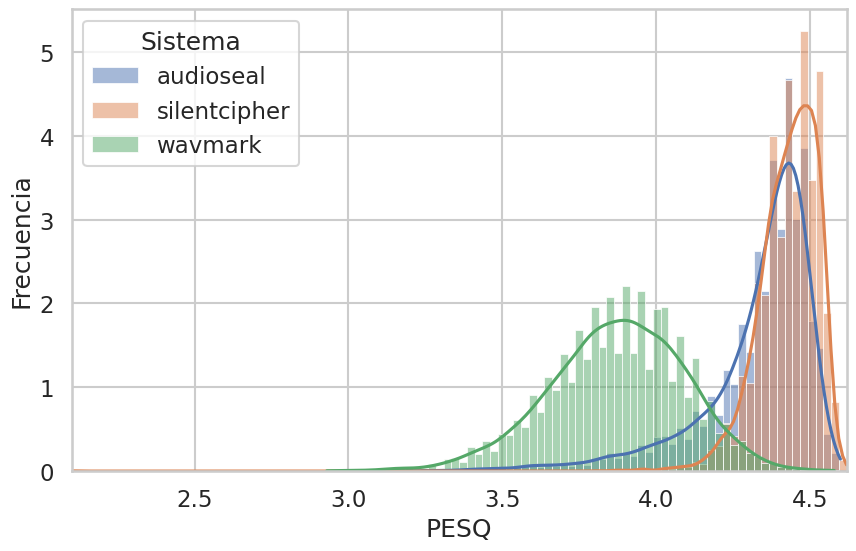

In [141]:
plt.figure(figsize=(10, 6))
plt.xlabel('PESQ')
plt.ylabel('Frecuencia')

pesq_min = min(data[system]['pesq_score'].min() for system in systems)
pesq_max = max(data[system]['pesq_score'].max() for system in systems)

bins = np.linspace(pesq_min, pesq_max, 101)  # 50 bins, 51 edges

for system, df in data.items():
    sns.histplot(data=df, x='pesq_score', bins=bins, kde=True, stat='density', label=system, alpha=0.5)
plt.legend(title='Sistema')
plt.xlim([pesq_min, pesq_max])
plt.savefig(plots_folder / 'pesq_combined.svg')
plt.show()

Grafico de la relación señal a ruido

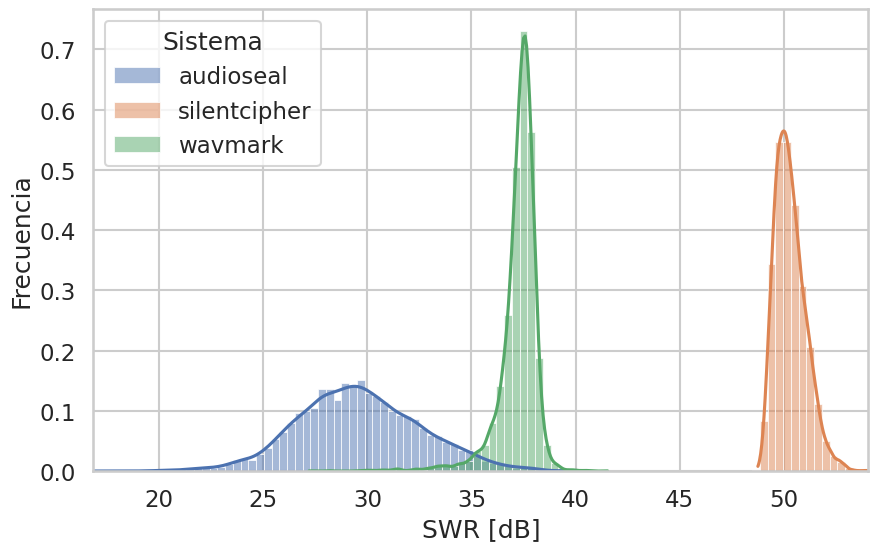

In [142]:
plt.figure(figsize=(10, 6))
plt.xlabel('SWR [dB]')
plt.ylabel('Frecuencia')

snr_min = min(data[system]['snr'].min() for system in systems)
snr_max = max(data[system]['snr'].max() for system in systems)

bins = np.linspace(snr_min, snr_max, 101)

for system, df in data.items():
    sns.histplot(data=df, x='snr', bins=bins, kde=True, stat='density', label=system, alpha=0.5)

plt.legend(title='Sistema')
plt.xlim([snr_min, snr_max])
plt.savefig(plots_folder / 'snr_combined.svg')
plt.show()

Scatter plot de la relación entre SNR y PESQ para cada ataque

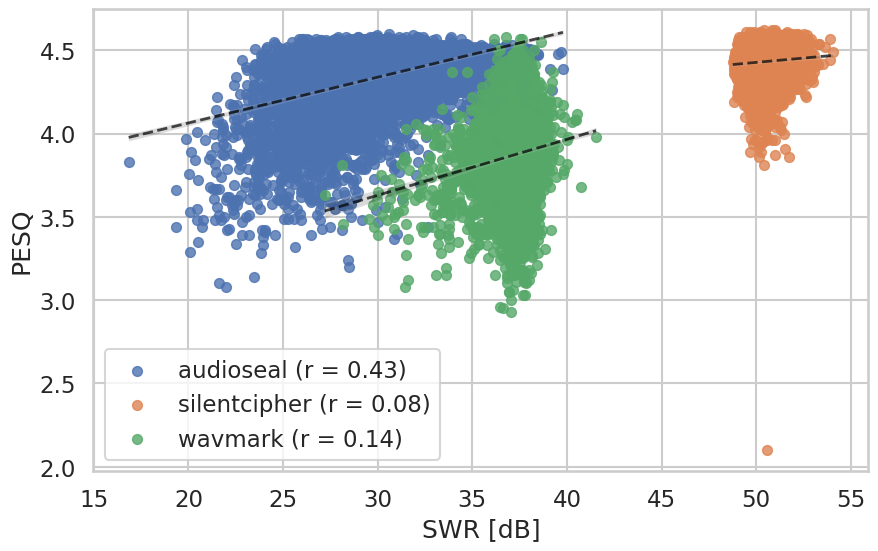

In [143]:
plt.figure(figsize=(10, 6))

for system in systems:
    pearson_corr = np.corrcoef(data[system]['snr'], data[system]['pesq_score'])[0, 1]
    sns.regplot(x='snr', y='pesq_score', data=data[system], label=f"{system} (r = {pearson_corr:.2f})", marker='o', scatter_kws={'s': 50}, fit_reg=False)
for system in systems:
    sns.regplot(x='snr', y='pesq_score', data=data[system], scatter=False, line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 2, 'alpha': 0.7})

plt.xlabel('SWR [dB]')
plt.ylabel('PESQ')
plt.legend()
plt.savefig(plots_folder / 'snr-pesq.svg')
plt.show()


In [144]:
# correlation, p_value = pearsonr(data['audioseal']['snr'], data['audioseal']['pesq'])
# print(f'Coeficiente de correlación de Pearson: {correlation}')
# print(f'Valor p: {p_value}')

# model = ols('pesq ~ C(attack) + snr', data=data['audioseal']).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)

# print(anova_table)

Plot del tiempo de inferencia de cada sistema

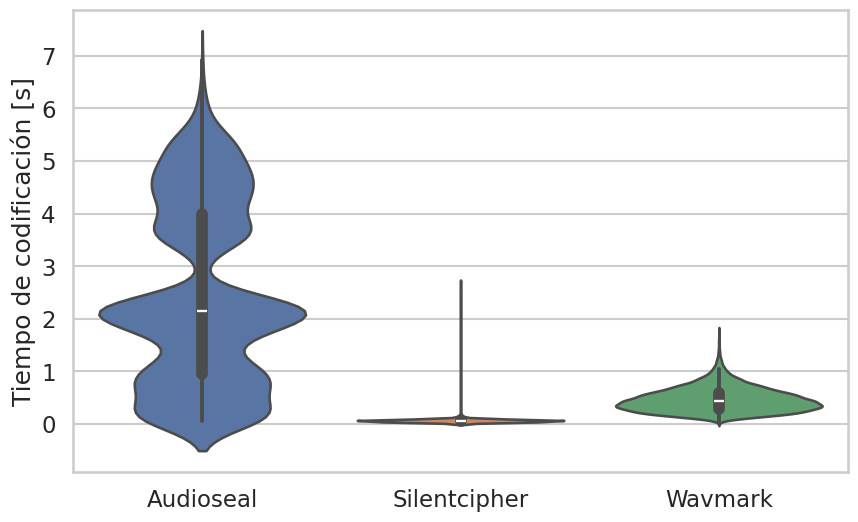

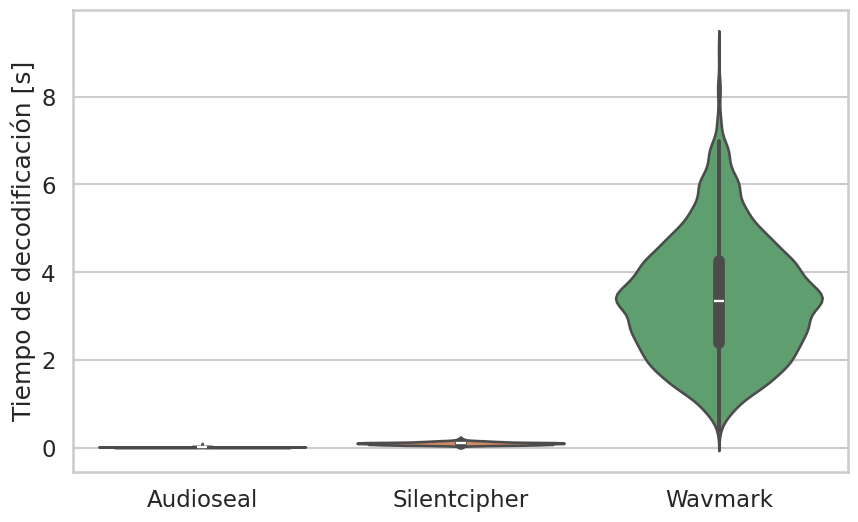

In [145]:
placeholder_data = pd.DataFrame({
    'time': pd.concat([data['audioseal']['encode_time'], data['silentcipher']['encode_time'], data['wavmark']['encode_time']]),
    'group': ['Audioseal'] * len(data['audioseal']) + ['Silentcipher'] * len(data['silentcipher']) + ['Wavmark'] * len(data['wavmark'])
})
plt.figure(figsize=(10, 6))
sns.violinplot(x='group', y='time', hue='group', legend=False, data=placeholder_data)
plt.ylabel('Tiempo de codificación [s]')
plt.xlabel('')
plt.savefig(plots_folder / "encode_time.svg")
plt.show()

placeholder_data = pd.DataFrame({
    'time': pd.concat([data['audioseal']['decode_time'], data['silentcipher']['decode_time'], data['wavmark']['decode_time']]),
    'group': ['Audioseal'] * len(data['audioseal']) + ['Silentcipher'] * len(data['silentcipher']) + ['Wavmark'] * len(data['wavmark'])
})
plt.figure(figsize=(10, 6))
sns.violinplot(x='group', y='time', hue='group', legend=False, data=placeholder_data)
plt.ylabel('Tiempo de decodificación [s]')
plt.xlabel('')
plt.savefig(plots_folder / "decode_time.svg")
plt.show()

Ahora voy a plotear el bit error rate para cada sistema

Audioseal: 0.00. stdev: 0.00
Wavmark: 0.00. stdev: 0.07
Silentcipher: 3.85. stdev: 18.28


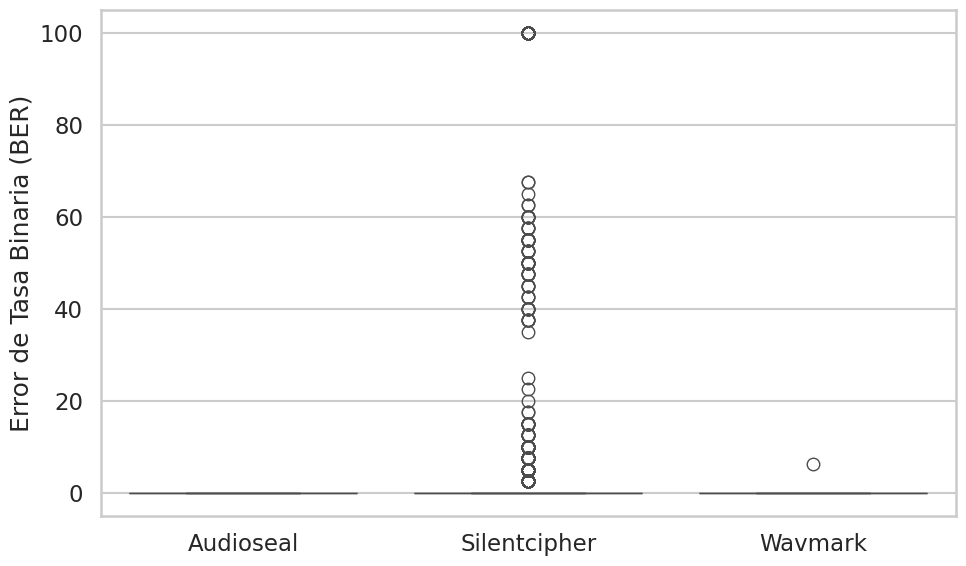

In [146]:
ber_df = pd.DataFrame({
    'System': ['Audioseal'] * len(data['audioseal']['ber']) + 
              ['Silentcipher'] * len(data['silentcipher']['ber']) +
              ['Wavmark'] * len(data['wavmark']['ber']),
    'BER': list(data['audioseal']['ber']) + list(data['silentcipher']['ber']) + list(data['wavmark']['ber'])
})

print(f"Audioseal: {data['audioseal']['ber'].mean():.2f}. stdev: {data['audioseal']['ber'].std():.2f}")
print(f"Wavmark: {data['wavmark']['ber'].mean():.2f}. stdev: {data['wavmark']['ber'].std():.2f}")
print(f"Silentcipher: {data['silentcipher']['ber'].mean():.2f}. stdev: {data['silentcipher']['ber'].std():.2f}")


plt.figure(figsize=(10, 6))
sns.boxplot(x='System', y='BER', data=ber_df, hue='System', legend=False)
plt.ylabel('Error de Tasa Binaria (BER)')
plt.xlabel('')
plt.tight_layout()
plt.savefig(plots_folder / "ber.svg")
plt.show()

Ahora quiero plotear el tiempo de inferencia normalizado con respecto a la duración de cada archivo

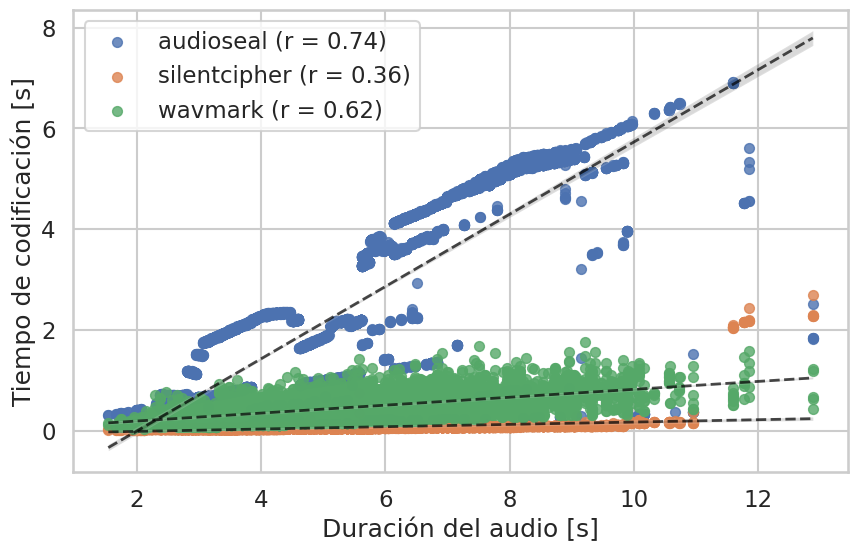

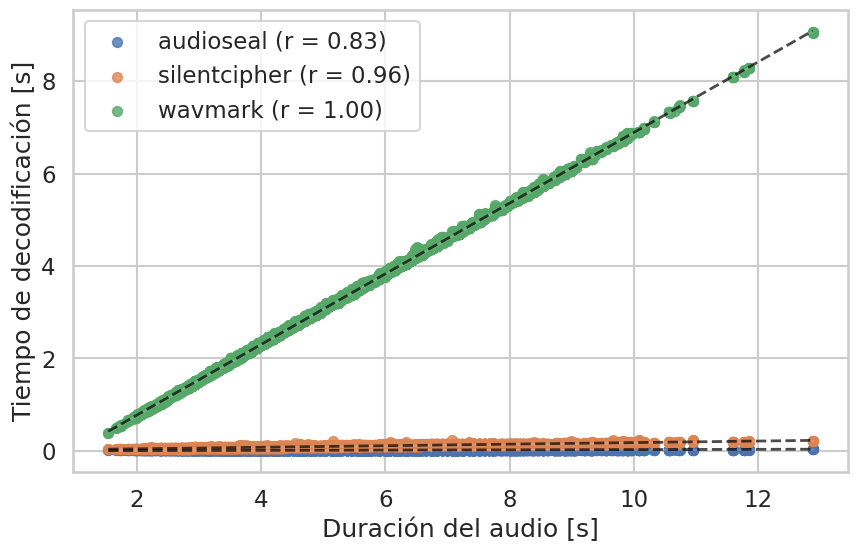

In [147]:

plt.figure(figsize=(10, 6))

for system in systems:
    pearson_corr = np.corrcoef(data[system]['duration'], data[system]['encode_time'])[0, 1]
    sns.regplot(x='duration', y='encode_time', data=data[system], label=f"{system} (r = {pearson_corr:.2f})", marker='o', scatter_kws={'s': 50}, fit_reg=False)
for system in systems:
    sns.regplot(x='duration', y='encode_time', data=data[system], scatter=False, line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 2, 'alpha': 0.7})

plt.xlabel('Duración del audio [s]')
plt.ylabel('Tiempo de codificación [s]')
plt.legend()
plt.savefig(plots_folder / "encode-dur.svg")
plt.show()

plt.figure(figsize=(10, 6))

for system in systems:
    pearson_corr = np.corrcoef(data[system]['duration'], data[system]['decode_time'])[0, 1]
    sns.regplot(x='duration', y='decode_time', data=data[system], label=f"{system} (r = {pearson_corr:.2f})", marker='o', scatter_kws={'s': 50}, fit_reg=False)
for system in systems:
    sns.regplot(x='duration', y='decode_time', data=data[system], scatter=False, line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 2, 'alpha': 0.7})

plt.xlabel('Duración del audio [s]')
plt.ylabel('Tiempo de decodificación [s]')
plt.legend()
plt.savefig(plots_folder / "decode-dur.svg")
plt.show()

Plots de los espectrogramas de las muestras

In [148]:
def plot_results(original, watermark_signal, watermarked_signal, sr, filename, results_folder):
    """
    Plots the spectrograms of the original audio, the watermark signal, and the watermarked audio.
    All spectrograms are normalized to the same reference decibel level (0 dB) for comparison.
    The dB range is limited between 0 dB and -80 dB for all plots.

    Args:
        original (np.array): Original audio signal.
        watermark_signal (np.array): The watermark signal.
        watermarked_signal (np.array): The audio signal with watermark applied.
        sr (int): Sampling rate of the audio signals.
        filename (str): The name of the audio file (for the title).
    """
    # Compute the Short-Time Fourier Transform (STFT) for each signal
    original_stft = np.abs(librosa.stft(original))
    watermark_stft = np.abs(librosa.stft(watermark_signal))
    watermarked_stft = np.abs(librosa.stft(watermarked_signal))
    
    # Find the maximum value across all STFTs to use as the reference for dB conversion
    max_value = max(original_stft.max(), watermark_stft.max(), watermarked_stft.max())
    
    # Convert the STFTs to decibel scale using the same reference
    original_spectrogram = librosa.amplitude_to_db(original_stft, ref=max_value)
    watermark_spectrogram = librosa.amplitude_to_db(watermark_stft, ref=max_value)
    watermarked_spectrogram = librosa.amplitude_to_db(watermarked_stft, ref=max_value)

    # Clip the dB range between 0 dB and -80 dB
    original_spectrogram = np.clip(original_spectrogram, -80, 0)
    watermark_spectrogram = np.clip(watermark_spectrogram, -80, 0)
    watermarked_spectrogram = np.clip(watermarked_spectrogram, -80, 0)

    # Create a figure with three subplots
    plt.figure(figsize=(10, 4))
    # Plot the watermark signal spectrogram
    plt.subplot(1, 2, 1)
    librosa.display.specshow(watermark_spectrogram, sr=sr, x_axis='time', y_axis='log', vmin=-80, vmax=0)
    plt.title('Marca de agua')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Frecuencia [Hz]')
    # Plot the watermarked audio spectrogram
    plt.subplot(1, 2, 2)
    librosa.display.specshow(watermarked_spectrogram, sr=sr, x_axis='time', y_axis='log', vmin=-80, vmax=0)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Audio + marca de agua')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('')
    plt.xticks()

    # Show plot
    output_file_path = results_folder / f"spectrogram_{filename}.svg"
    output_file_path_png = results_folder / f"spectrogram_{filename}.png"

    plt.savefig(output_file_path, bbox_inches='tight')
    plt.savefig(output_file_path_png)
    plt.tight_layout()
    plt.show()

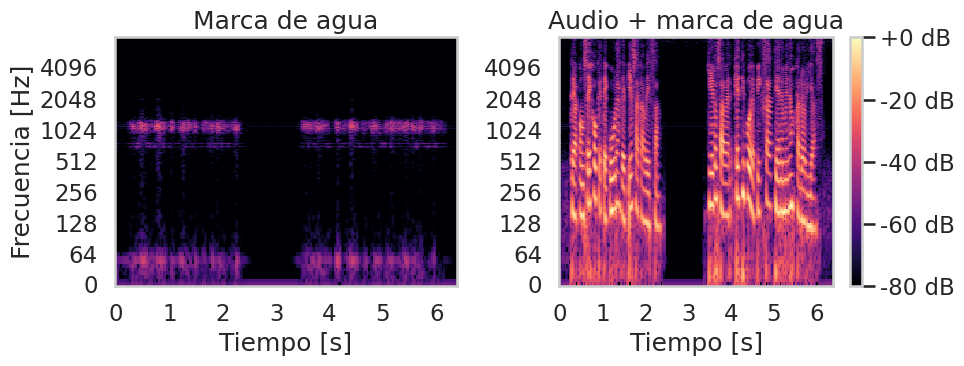

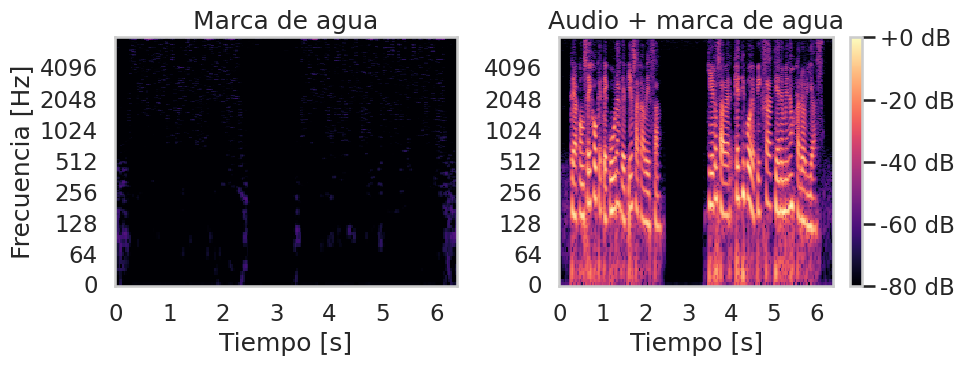

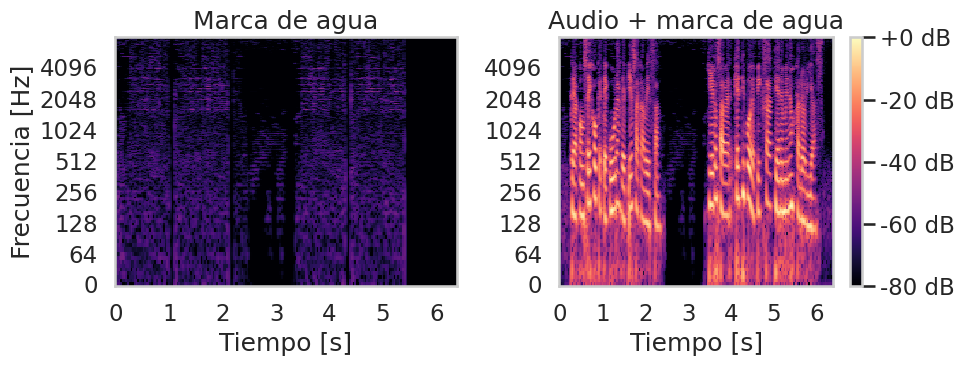

In [149]:
audio_original = sf.read('data/audio_samples/original/F1_or.wav')[0]
# Lista de archivos de audio
audios = [sf.read('data/audio_samples/audioseal/F1_as.wav')[0], 
          sf.read('data/audio_samples/silentcipher/F1_sc.wav')[0], 
          sf.read('data/audio_samples/wavmark/F1_wm.wav')[0]]

SR = 16000

watermark = audios[0] - audio_original
plot_results(audio_original, watermark, audios[0], SR, 'audioseal', Path.cwd())

watermark = audios[1][:-1] - audio_original
plot_results(audio_original, watermark, audios[1], SR, 'silentcipher', Path.cwd())

watermark = audios[2] - audio_original
plot_results(audio_original, watermark, audios[2], SR, 'wavmark', Path.cwd())

In [150]:
# Leer los dos archivos de audio
sample_rate1, data1 = wavfile.read('data/audio_samples/original/F1_or.wav')
sample_rate2, data2 = wavfile.read('data/audio_samples/audioseal/F1_as.wav')

# Asegurarse de que ambos audios tengan el mismo sample rate
if sample_rate1 != sample_rate2:
    raise ValueError("Los archivos de audio tienen diferentes tasas de muestreo.")

# Asegurarse de que ambos audios tengan la misma longitud
if len(data1) != len(data2):
    # Redimensionar la señal más corta para que coincida con la más larga
    min_len = min(len(data1), len(data2))
    data1 = data1[:min_len]
    data2 = data2[:min_len]

# Restar las señales punto a punto
diff = data2 - data1

# Guardar el resultado como un nuevo archivo de audio
wavfile.write('data/audio_samples/F1_as_wm.wav', sample_rate1, diff)

print("Archivo de diferencia guardado como 'audio_diff.wav'")

Archivo de diferencia guardado como 'audio_diff.wav'


In [151]:
ber_dict = {}
ber_df = {}
averages = {}

for system in systems:
    ber_dict[system] = audio_folder / system / 'results' / 'ber_results.csv'
    ber_df[system] = pd.read_csv(ber_dict[system])
    averages[system] = ber_df[system].drop(columns=['file_name']).mean()
    print(averages[system])

ber              0.000000
ber_opus_6k     34.921695
ber_opus_12k     2.414511
ber_opus_24k     0.000718
dtype: float64
ber              3.897541
ber_opus_6k     82.742501
ber_opus_48k    12.462935
ber_opus_24k    30.904494
ber_opus_12k    58.727445
dtype: float64
ber              0.000718
ber_opus_12k    35.979167
dtype: float64


In [152]:
samples_path = Path('data/audio_samples')

wav_files = list(samples_path.rglob("*.wav"))

for file in wav_files:
    data, sr = sf.read(file)
    print(f"Archivo {file}. Duración: {len(data)/sr} segundos.")


Archivo data/audio_samples/F1_wm_wm.wav. Duración: 6.392375 segundos.
Archivo data/audio_samples/F1_sc_wm.wav. Duración: 6.392375 segundos.
Archivo data/audio_samples/F1_as_wm.wav. Duración: 6.392375 segundos.
Archivo data/audio_samples/audioseal/F2_as.wav. Duración: 7.0036875 segundos.
Archivo data/audio_samples/audioseal/M1_as.wav. Duración: 6.8604375 segundos.
Archivo data/audio_samples/audioseal/F1_as.wav. Duración: 6.392375 segundos.
Archivo data/audio_samples/audioseal/M2_as.wav. Duración: 7.213625 segundos.
Archivo data/audio_samples/calibration/cal.wav. Duración: 6.314625 segundos.
Archivo data/audio_samples/original/F1_or.wav. Duración: 6.392375 segundos.
Archivo data/audio_samples/original/M1_or.wav. Duración: 6.8604375 segundos.
Archivo data/audio_samples/original/M2_or.wav. Duración: 7.213625 segundos.
Archivo data/audio_samples/original/F2_or.wav. Duración: 7.0036875 segundos.
Archivo data/audio_samples/silentcipher/M2_sc.wav. Duración: 7.2136875 segundos.
Archivo data/aud